# Setup 

In [26]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import torch.nn as nn
import numpy as np
import shutil #to remove folder

import itertools
import random

import matplotlib.pyplot as plt

import wandb
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecVideoRecorder
from wandb.integration.sb3 import WandbCallback

%matplotlib notebook

custom_objects = {
    "lr_schedule": lambda x: .003,
    "clip_range": lambda x: .02
}

import imageio as iio
import os

In [1]:
# Create gif out of environment and agent. Possibly upload to W&B
# gif_name: ["hacked", "initial_changed_env"] (have mappings in W&B) or custom
def save_gif(gif_name, max_frames, max_episodes, model, env, log_to_wb = True):

    path = 'gif'

    #remove folder as might contain old files
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

  # Create a new directory 
    os.makedirs(path)

    images = []
    gif_path = gif_name + ".gif"
    frames_path = path+"/"+gif_name+"{j}.jpg"


    j = 0
    obs = env.reset()
    img = env.render(mode='rgb_array', highlight=False)
    for i in range(max_episodes):
        obs = env.reset()
        while True and j < max_frames:
            action, _ = model.predict(obs)
            obs, r, done ,_ = env.step(action)
            fig,(ax1) = plt.subplots(1,1, figsize=(5, 5));
            image1 = ax1.imshow(env.render("rgb_array", highlight=False))
            ax1.set_title(f"Hacked obs: Action = {action}, Reward = {r}, \n Done = {done}")
            plt.savefig(frames_path.format(j=j))
            plt.cla()
            j=j+1 
            if done: 
                break
    with iio.get_writer(gif_path, mode='I') as writer:
        for j in range(max_frames):
            try:
                writer.append_data(iio.imread(frames_path.format(j=j)))
            except OSError as e:
                None
    if log_to_wb == True:
        wandb.log({gif_name: wandb.Video(gif_path)})

In [11]:
def save_gif2(gif_name, max_frames, max_episodes, model, env, log_to_wb = True):
    agent1_actions = {
    0: 'Turn left', 1: 'Turn right', 2: 'Move forward',
    3: 'Pickup', 4: 'Drop', 5:'Toggle', 6: 'Done'
    }
    agent2_actions = {
        0: 'Up 1', 1: 'Right 1', 2: 'Down 1', 3: "Left 1",
        4: 'Up 2', 5: 'Right 2', 6: 'Down 2', 7: "Left 2"
    }
    
    path = 'gif'

    #remove folder as might contain old files
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

  # Create a new directory 
    os.makedirs(path)

    images = []
    gif_path = gif_name + ".gif"
    frames_path = path+"/"+gif_name+"{j}.jpg"


    j = 0
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5));
    for i in range(max_episodes):
        obs = env.reset()
        if i == 0:
            img1 = ax1.imshow(env.render(pov='agent', highlight=False))
            img2 = ax2.imshow(env.render(pov='original', highlight=False))
        else:
            img1.set_data(env.render(pov='agent', highlight=False))
            img2.set_data(env.render(pov='original', highlight=False))
            
        while True and j < max_frames:
            action, _ = model.predict(obs)
            obs, r, done ,_ = env.step(action)
            img1.set_data(env.render(pov='agent', highlight=False))
            img2.set_data(env.render(pov='original', highlight=False))
            fig.suptitle(f'Reward: {r:.5f}', fontsize=16, y=1)
            ax1.set_title(f"Agent 1: {agent1_actions[env.environment_action]}")
            ax2.set_title(f"Agent 2: {agent2_actions[action]} ")
            fig.canvas.draw()
            fig.savefig(frames_path.format(j=j))
            j=j+1 
            if done: 
                break
    
    with iio.get_writer(gif_path, mode='I') as writer:
        for j in range(max_frames):
            try:
                writer.append_data(iio.imread(frames_path.format(j=j)))
            except OSError as e:
                None
    if log_to_wb == True:
        wandb.log({gif_name: wandb.Video(gif_path)})
    

In [4]:
#Vanilla environment for first agent
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=9, ball_color="green", tile_size=8):
        self.ball_color = ball_color
        self.tile_size = tile_size
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(size * tile_size, size * tile_size, 3),
            dtype='uint8'
        )
    
    def reset(self):
        super().reset()
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        return rgb_observation
        
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)
        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True
        
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        
        return rgb_observation, reward, done, info

In [28]:
#Wrapper to change starting ball color randomly
class RandomBallColorWrapper(gym.core.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
    
    def reset(self):
        self.env.ball_color = random.sample(["red", "green", "blue", "yellow", "purple"], 1)[0]
        return super().reset()
    
class RandomBallColorWrapper2(gym.core.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
    
    def reset(self):
        self.env.ball_color = random.sample(["red", "blue", "yellow", "purple"], 1)[0]
        return super().reset()

In [6]:
# Hacked environment wrapper
class HackedEnvironment(gym.core.Wrapper):
    COLOR_TO_INDEX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4}
    INDEX_TO_COLOR = {0: "red", 1: "green", 2: "blue", 3: "purple", 4: "yellow"}
    
    
    def __init__(self, env, first_agent):
        self.first_agent = first_agent
        super().__init__(env)
        self.action_space = spaces.Discrete(8)
        
        # Action performed by second agent
        self.transformation_action = None
        # Action performed by first agent
        self.environment_action = None
        self.done = False
        self.reset()
        
    def reset(self):
        self.env.reset()
        self.done = False
        self.transformation_action = None
        original_obs = self.transformed_obs = self.env.render(
            "rgb_image",
            highlight=False,
            tile_size=self.env.tile_size
        )
        return original_obs

    def _perform_action(self, controller_action):
        # Perform second agent's action
        
        """
        0-4 are 1-step actions. 5-7 are 2-step actions. Order is up, right, down, left
        """
        grid_size = self.env.width
        agent_loc = self.env.agent_pos
        ball_loc = self.ball.cur_pos
        # Take correct ball away
        self.env.grid.set(ball_loc[0], ball_loc[1], None)
        temp_ball_loc = None
        
        if controller_action == 0:
            if agent_loc[1]-1 >= 0:
                temp_ball_loc = [agent_loc[0], agent_loc[1]-1]
        elif controller_action == 1:
            if agent_loc[0]+1 <= grid_size-1:
                temp_ball_loc = [agent_loc[0]+1, agent_loc[1]]
        elif controller_action == 2:
            if agent_loc[1]+1 <= grid_size-1:
                temp_ball_loc = [agent_loc[0], agent_loc[1]+1]
        elif controller_action == 3:
            if agent_loc[0]-1 >= 0:
                temp_ball_loc = [agent_loc[0]-1, agent_loc[1]]
        elif controller_action == 4:
            if agent_loc[1]-2 >= 0:
                temp_ball_loc = [agent_loc[0], agent_loc[1]-2]
        elif controller_action == 5:
            if agent_loc[0]+2 <= grid_size-1:
                temp_ball_loc = [agent_loc[0]+2, agent_loc[1]]
        elif controller_action == 6:
            if agent_loc[1]+2 <= grid_size-1:
                temp_ball_loc = [agent_loc[0], agent_loc[1]+2]
        elif controller_action == 7:
            if agent_loc[0]-2 >= 0:
                temp_ball_loc = [agent_loc[0]-2, agent_loc[1]]
                
        if temp_ball_loc is not None:
            self.env.grid.set(temp_ball_loc[0], temp_ball_loc[1], Ball(color=self.ball.color))
        return temp_ball_loc
    
    def step(self, controller_action):
        """
        This agent changes some random color from predefined colors to goal color. If that color does
        not exist then nothing changes.
        
        1) 2nd agent makes an action and changes ball's color
        2) Render changed environment (change ball color in environment)
            which will be inserted to first agent's model
        3) First agent returns action and perform it on real environment
        4) Change ball color back to real ball color
        """
        # Save second agent's action
        self.transformation_action = controller_action
        
        # Perform second agent's action
        ball_loc = self.ball.cur_pos
        ball_color = self.ball.color
        self.ball.color = 'green'
        
        temp_ball_loc = self._perform_action(controller_action)
        
        # Change ball's color
        
        
        # Get transformed environemnt
        transformed_obs = self.env.render("rgb_image", highlight=False, tile_size=self.env.tile_size)    
        # Give first agent transformed transformed image and get first agent movement prediction
        first_action, _ = self.first_agent.predict(transformed_obs)
        
        # Change ball color back
        self.ball.color = ball_color
        
        # Save first agent's action
        self.environment_action = first_action
        
        
        # Remove 'wrong' ball
        if temp_ball_loc is not None:
            self.env.grid.set(temp_ball_loc[0], temp_ball_loc[1], None)
            if (temp_ball_loc[0] in [0, self.env.width-1]) or (temp_ball_loc[1] in [0, self.env.width-1]):
                self.env.put_obj(Wall(), temp_ball_loc[0], temp_ball_loc[1])
        # Put real ball back to world
        self.env.grid.set(ball_loc[0], ball_loc[1], self.ball)
        
        # Create obs, rew, done, info
        original_obs, reward, self.done, info = self.env.step(first_action)

        return original_obs, reward, self.done, info
        
    def render(self, pov="agent", highlight=False, **kwargs):
        """
        pov : agent / original
        """
        if pov=="agent":
            if self.transformation_action == None or self.done:
                return self.render(pov='original')
            ball_color = self.env.ball.color
            self.ball.color = 'green'
            ball_loc = self.ball.cur_pos
            temp_ball_loc = self._perform_action(self.transformation_action)
            
            observation = self.env.render(highlight=highlight, **kwargs)
            # Return original picture
            self.env.ball.color = ball_color
            if temp_ball_loc is not None:
                self.env.grid.set(temp_ball_loc[0], temp_ball_loc[1], None)
                if (temp_ball_loc[0] in [0, self.env.width-1]) or (temp_ball_loc[1] in [0, self.env.width-1]):
                    self.env.put_obj(Wall(), temp_ball_loc[0], temp_ball_loc[1])
            self.env.grid.set(ball_loc[0], ball_loc[1], self.ball)
            
        else:
            observation = self.env.render(highlight=highlight, **kwargs)
        return observation

# Experiments

Sets up following experiments: 


1.   train_and_log_baseline - trains 1st agent and logs related data to W&B
2.   validate_baseline - validates 1st agent on the second environment. 
3.   train_2nd_agent_and_validate - trains second agent and validates it on second environment. 

Note: only experiments 2 and 3 are assumed to get changed with different environment changes. They also need the first agent to be provided for loading. 


## Experiment definitions

In [31]:
def validate_baseline2(trial_description, trial_name, config, modelName = "first_agent", randomColor = False):
  ### Initiate W&B connection
    project_name = "learning-by-hacking"
    run = wandb.init(
        project=project_name,
        entity="learning-by-hacking",
        name = trial_name,
        config=config,
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        monitor_gym=True,  # auto-upload the videos of agents playing the game
        save_code=True,  # optional
    )
    env = EmptyBallRoom()
    agent = PPO.load('first_agent', device='cuda')
    
    agent2 = PPO.load(modelName)
  ### Load agent
    print("loaded:", "gamma =", agent2.gamma, "n_steps =", agent2.n_steps)

  ############################################################################################################## 
  # Only this section is expected to get changed per different experiments

  ### choose random color or not
    if randomColor == False:
        env2 = HackedEnvironment(env, agent)    
    else:
        env = RandomBallColorWrapper(env)
        env2 = HackedEnvironment(env, agent)

  ############################################################################################################## 
  
  ### Validate
    n_val_episodes = 1000
    mean_reward, std_reward = evaluate_policy(agent2, env2, n_eval_episodes=n_val_episodes)
    wandb.log({'val_mean_reward': mean_reward, 'val_std_reward': std_reward}) #log mean reward
    
    if randomColor:
        env = RandomBallColorWrapper2(EmptyBallRoom())
        env2 = HackedEnvironment(env, agent)
    
    save_gif2("Second agent's performance", 100, 10, agent2, env2, log_to_wb = True) #log gif to W&B

    wandb.finish() 


In [22]:
env =RandomBallColorWrapper( EmptyBallRoom())
agent = PPO.load('first_agent', device='cuda')
env2 = HackedEnvironment(env, agent)
agent2 = PPO.load('Hans_and_Grete_COLOR_v2')

<IPython.core.display.Javascript object>


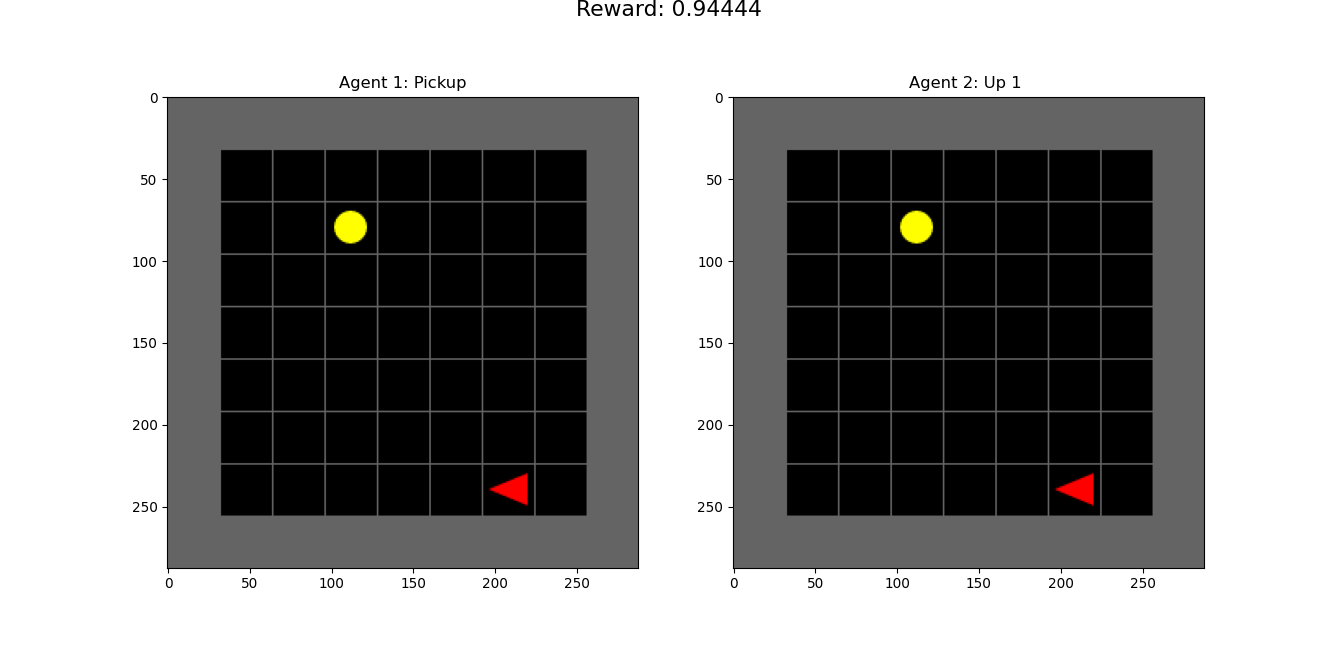

<IPython.core.display.Javascript object>


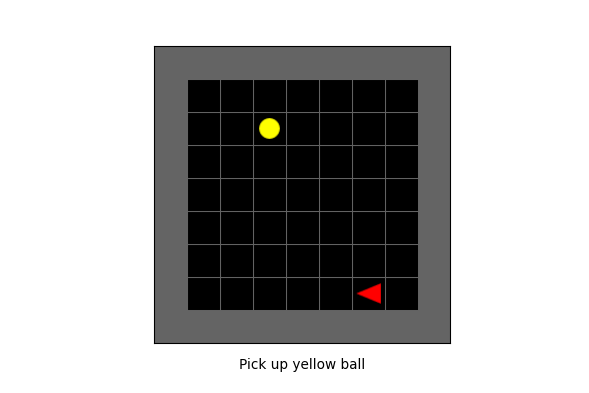

In [27]:
save_gif2('test', 100, 10, agent2, env2, log_to_wb = False)

## Running the experiments

loaded: gamma = 0.5 n_steps = 2048


<IPython.core.display.Javascript object>


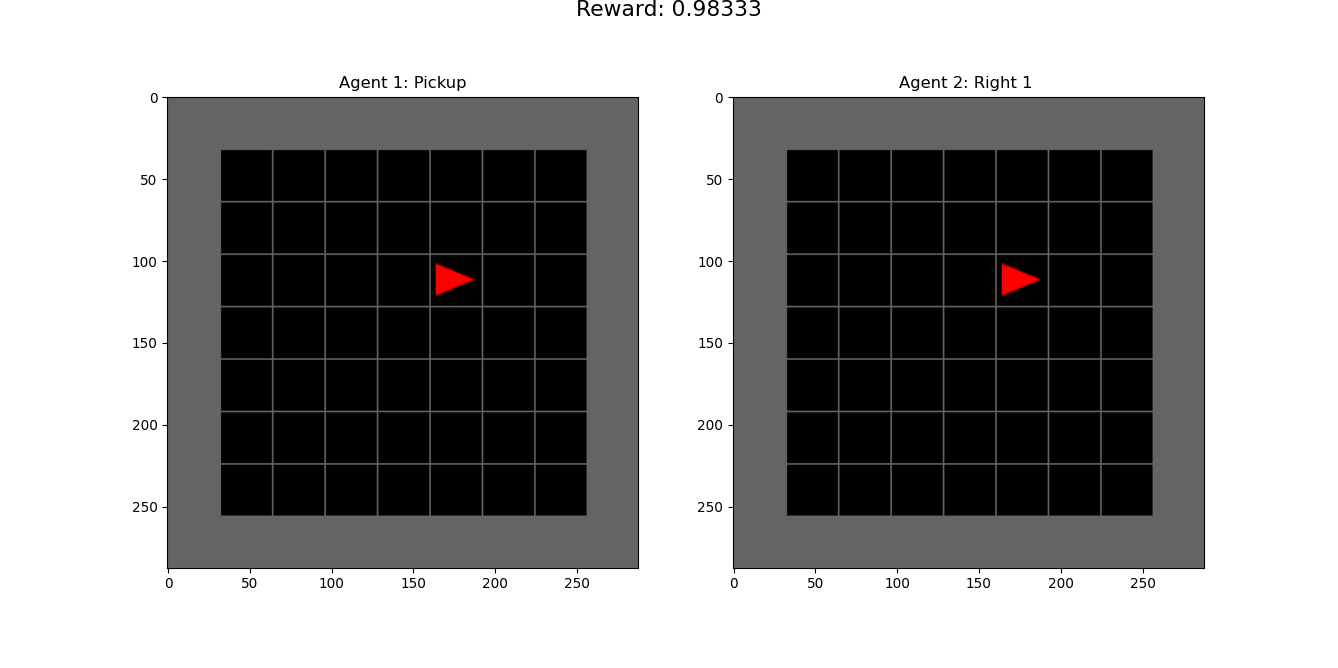

<IPython.core.display.Javascript object>


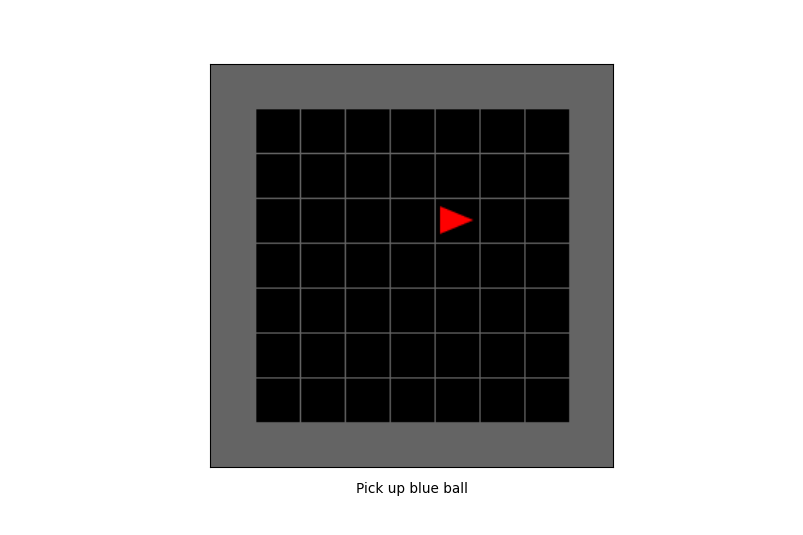

val_mean_reward,▁
val_std_reward,▁
val_mean_reward,0.92194
val_std_reward,0.21483


In [32]:
trial_description = 'Second agent places new ball near the first agent and tries to lead first agent. Initial ball color is set randomly.'

config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 4_000_000, #irrelevent here
    "env_name": "Baseline 2",
    "ROOM_SIZE": 9,
    "BALL_COLOR": "random",
    "2ND_BALL_COLOR": "green",
    "TILE_SIZE": 8,
    "Trial description": trial_description
}

validate_baseline2(trial_description,
                   'Hans&Grete for random color ball', 
                    config, 
                    modelName='Hans_and_Grete_COLOR_v2',
                    randomColor=True)